# Лабораторная работа №4

ФИО: Калинин Егор Андреевич
Группа: БИВТ-21-3


## Задание

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/11600OkqdRzxc-xZmFTuBs099VeAqU_GlE0Bx6bBlIRE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

## 1. Пример импорта данных. Грузим данные

In [1]:
import pandas as pd
data = pd.read_csv("exams.csv", sep=',') 
print(data.columns)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


## 2. Понимаем, какая перед нами задача

Цель:

Научиться применять различные методы машинного обучения для решения задачи регрессии. Научиться загружать и предобрабатывать данные, обучать модели, оценивать их производительность и сравнивать результаты.

Тип задачи:

В данном случае задача регрессии, поскольку итоговая оценка ученика по предмету(G3), является непрерывной числовой переменной.

## 3. Делаем предобработку данных

In [2]:
# Разделение данных на тренировочную и тестовую выборки
train = data[int(len(data)*0.2):]  
test = data[:int(len(data)*0.2)]

In [3]:
# Проверка пропусков в данных
print(train.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Определение численных и категориальных столбцов
num_cols = ['math score', 'reading score', 'writing score', 'test preparation course']
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch']
# Создание преобразователя колонок
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(), cat_cols)])

# Применение преобразований к тренировочным и тестовым данным
train_preprocessed = preprocessor.fit_transform(train)
test_preprocessed = preprocessor.transform(test)

print("Данные до преобразования:")
print(train.head())

# Преобразование в DataFrame (это не обязательно, но может быть полезно для дальнейшего анализа)
train_preprocessed_df = pd.DataFrame(train_preprocessed)
test_preprocessed_df = pd.DataFrame(test_preprocessed)

# Вывод преобразованных данных
print("\nРазделение по группам:")
print(preprocessor.get_feature_names_out(), "\n\n")
print("\nПреобразованные данные:")
print(train_preprocessed_df.head())

Данные до преобразования:
     gender race/ethnicity parental level of education         lunch  \
200  female        group D          associate's degree      standard   
201    male        group E          associate's degree      standard   
202    male        group C                some college      standard   
203  female        group B            some high school      standard   
204  female        group D          associate's degree  free/reduced   

     test preparation course  math score  reading score  writing score  
200                        1          50             63             65  
201                        0          55             54             47  
202                        0          77             64             70  
203                        1          49             64             67  
204                        0          66             83             82  

Разделение по группам:
['num__math score' 'num__reading score' 'num__writing score'
 'num__test prepar

## 4. Оформление данных

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Определение класса Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

y = train_preprocessed[:, len(num_cols) - 1] # только G3
y_test = test_preprocessed[:, len(num_cols) - 1] # только G3
x = np.delete(train_preprocessed, len(num_cols) - 1, axis=1) # все столбцы, кроме G3
x_test = np.delete(test_preprocessed, len(num_cols) - 1, axis=1) # все столбцы, кроме G3

# Создание экземпляров MyDataset
train_dataset = CustomDataset(torch.from_numpy(x).float(), torch.from_numpy(y).float())
test_dataset = CustomDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())

# Загрузка данных в DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=7, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=7, shuffle=False)

# Проверка работы DataLoader
for data, target in train_dataloader:
    print("Batch data:", data)
    print("Batch target:", target)
    break  

Batch data: tensor([[-1.2170, -0.9053,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000],
        [ 1.4522,  1.0021,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000],
        [ 0.5408,  0.0484,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000],
        [-0.0452,  0.1165,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000],
        [ 0.1501,  1.0021,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.

## 5. Обучение на тренировочном множестве

### 5.1 Определение моделей

In [6]:
import torch.nn as nn
import torch.optim as optim

In [7]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
class OneHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OneHiddenLayerNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

In [9]:
class MultiLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLayerNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer4(out)
        return out

### 5.2 Определение тренировочного класса

In [13]:
class ModelTrainer:
    def __init__(self, model, useAdam, modelName):
        self.model = model
        self.criterion = nn.MSELoss()
        self.modelName = modelName
        self.optimizer = self._choose_optimizer(useAdam)

    def _choose_optimizer(self, useAdam):
        if useAdam:
            return optim.Adam(self.model.parameters(), lr=0.01)
        else:
            return optim.SGD(self.model.parameters(), lr=0.01)

    def _train_epoch(self, trainData):
        self.model.train()
        train_loss = 0
        for inputs, targets in trainData:
            inputs, targets = self._prepare_data(inputs, targets)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
        return train_loss / len(trainData)

    def _prepare_data(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.float().view(-1, 1)
        return inputs, targets

    def doTrain(self, epoches, trainData, testData):
        train_losses, test_losses = [], []
        for epoch in range(epoches):
            train_losses.append(self._train_epoch(trainData))
            test_losses.append(self.testModel(testData))
            print(f"Finished training of epoch - {epoch} with train loss - {train_losses[-1]} and test loss - {test_losses[-1]}")
        return train_losses, test_losses  

    def testModel(self, testData):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in testData:
                inputs, targets = self._prepare_data(inputs, targets)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                test_loss += loss.item()
        return test_loss / len(testData)

    def getMae(self, testData):
        self.model.eval()
        mae = 0
        mae_criterion = nn.L1Loss()
        with torch.no_grad():
            for inputs, targets in testData:
                inputs, targets = self._prepare_data(inputs, targets)
                outputs = self.model(inputs)
                mae += mae_criterion(outputs, targets).item()
        return mae / len(testData)

### 5.3 Инициализация и обучение моделей

Finished training of epoch - 0 with train loss - 0.24691896219130444 and test loss - 0.06176659734598521
Finished training of epoch - 1 with train loss - 0.06257780017331242 and test loss - 0.0515879486719596
Finished training of epoch - 2 with train loss - 0.05802549224184907 and test loss - 0.04835786856710911
Finished training of epoch - 3 with train loss - 0.05596605816694058 and test loss - 0.048379928162642596
Finished training of epoch - 4 with train loss - 0.05591736413619441 and test loss - 0.04632493063550571
Finished training of epoch - 5 with train loss - 0.055357290731500024 and test loss - 0.04661307503180257
Finished training of epoch - 6 with train loss - 0.05518212816475526 and test loss - 0.04743047032890649
Finished training of epoch - 7 with train loss - 0.05501630481980417 and test loss - 0.04642932508783094
Finished training of epoch - 8 with train loss - 0.055259301088264455 and test loss - 0.04735950910454166
Finished training of epoch - 9 with train loss - 0.05

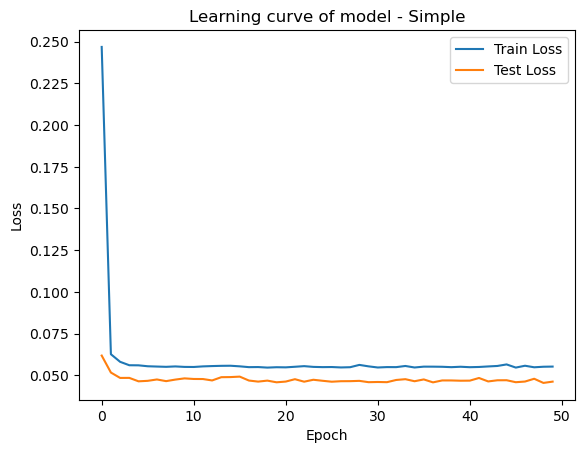

Finished training of epoch - 0 with train loss - 0.1384750745056764 and test loss - 0.061988235419166496
Finished training of epoch - 1 with train loss - 0.0684977457413207 and test loss - 0.056970200469267776
Finished training of epoch - 2 with train loss - 0.06623624517055957 and test loss - 0.056936073951937
Finished training of epoch - 3 with train loss - 0.06985371082049349 and test loss - 0.08383967997185116
Finished training of epoch - 4 with train loss - 0.06522056609797089 and test loss - 0.06211385927323637
Finished training of epoch - 5 with train loss - 0.06549597579742904 and test loss - 0.08058479421868406
Finished training of epoch - 6 with train loss - 0.06674677537268271 and test loss - 0.08102593198418617
Finished training of epoch - 7 with train loss - 0.05888947429864303 and test loss - 0.08481150749942352
Finished training of epoch - 8 with train loss - 0.061675599095938 and test loss - 0.07884870925597076
Finished training of epoch - 9 with train loss - 0.05747651

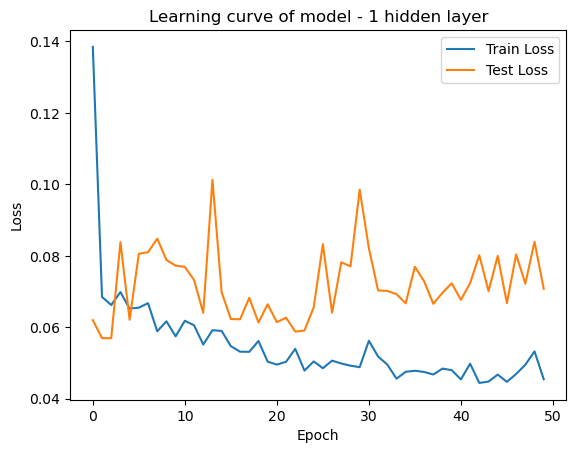

Finished training of epoch - 0 with train loss - 0.17585085519468008 and test loss - 0.17064879449277087
Finished training of epoch - 1 with train loss - 0.08071569378447274 and test loss - 0.057660683893181124
Finished training of epoch - 2 with train loss - 0.08727360169362763 and test loss - 0.06578656915446808
Finished training of epoch - 3 with train loss - 0.06467766112688443 and test loss - 0.06678444892168045
Finished training of epoch - 4 with train loss - 0.09827524761304907 and test loss - 0.0550619565785445
Finished training of epoch - 5 with train loss - 0.08736538822236269 and test loss - 0.06831048139981155
Finished training of epoch - 6 with train loss - 0.06332703310510386 and test loss - 0.07461241395052137
Finished training of epoch - 7 with train loss - 0.06863433747025935 and test loss - 0.0651227068156004
Finished training of epoch - 8 with train loss - 0.06367474590306697 and test loss - 0.07383019380785268
Finished training of epoch - 9 with train loss - 0.06600

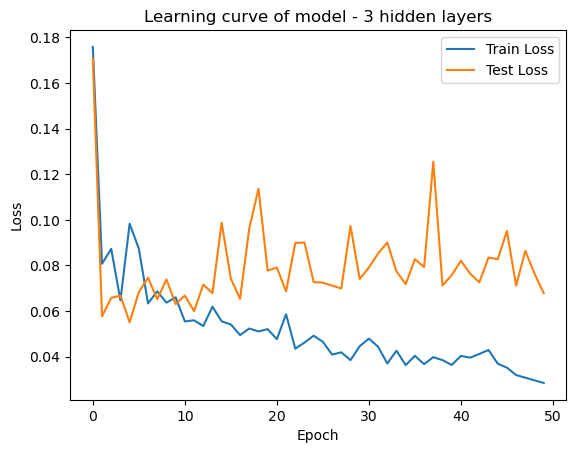

In [29]:
input_size = 19
output_size = 1
hidden_size = 100

models =[
    ModelTrainer(SimpleNet(input_size, output_size), False, "Simple"),
    ModelTrainer(OneHiddenLayerNet(input_size, hidden_size, output_size), True, "1 hidden layer"),
    ModelTrainer(MultiLayerNet(input_size, hidden_size, output_size), True, "3 hidden layers")
]

import matplotlib.pyplot as plt
for model in models:
    train_losses, test_losses = model.doTrain(50, train_dataloader, test_dataloader)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title("Learning curve of model - " + model.modelName)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## 6. Подсчет метрик

In [30]:
for model in models:
    train_mae = model.getMae(train_dataloader)
    test_mae = model.getMae(test_dataloader)
    print(f"Model {model.modelName} - Train MAE: {train_mae}, Test MAE: {test_mae}")

Model Simple - Train MAE: 0.18867227642432502, Test MAE: 0.1747295031773633
Model 1 hidden layer - Train MAE: 0.15426600309817687, Test MAE: 0.20851527437053877
Model 3 hidden layers - Train MAE: 0.12294510502530182, Test MAE: 0.20508399066226235


## 7. Сравнение метрик

#### Какая модель справилась лучше с поставленной задачей?

Сравнивая значения Mean Absolute Error (MAE) для тестовых данных, можно определить, что Model Simple справилась с задачей лучше остальных моделей, поскольку у неё наименьшее значение MAE на тестовых данных

#### Имеет ли место переобучение?

Переобучение происходит, когда модель показывает значительно лучшие результаты на тренировочных данных по сравнению с тестовыми данными. Это можно определить по разнице между MAE на тренировочных и тестовых данных.Наибольшую разницу между тренировочной и тестовой ошибкой показывают модели с одним и тремя скрытыми слоями. Особенно заметно переобучение в модели с тремя скрытыми слоями.

#### Имеет ли место недообучение?

Недообучение происходит, когда модель не показывает хороших результатов ни на тренировочных, ни на тестовых данных, что указывает на недостаточную сложность модели или её недостаточное обучение.

Model Simple имеет небольшую разницу между тренировочной и тестовой ошибкой, но её MAE на тренировочных данных выше, чем у других моделей. Это может указывать на некоторый уровень недообучения, так как её производительность на тренировочных данных хуже.

#### Как можно улучшить метрики моделей?

Есть несколько способов улучшить метрики моделей:
1. Увеличить количество данных.
2. Регуляризация.
3. Использование других моделей.